# Music-driven VQGAN Animations

This notebook is a version of https://colab.research.google.com/github/chigozienri/VQGAN-CLIP-animations/blob/main/VQGAN-CLIP-animations.ipynb that adds audio reactive functionality. For clarity, only the instructions relating to the music-reactive functionality are given here - for basic usage, refer to that notebook.

<h2>Donation Link</h2>

If you want, you can donate to support me at <a href="https://ko-fi.com/chigozie">ko-fi</a>. No pressure (but I'd love to know if you create a squillion-dollar NFT, or just had fun!).

<a href='https://ko-fi.com/chigozie' target='_blank'><img height='36' style='border:0px;height:36px;' src='https://cdn.ko-fi.com/cdn/kofi2.png?v=3' border='0' alt='Buy Me a Coffee at ko-fi.com' /></a>

<h2>Too complicated? Want more?</h2>

If you want a custom animation, features not included here, or anything else, let me know. I might be up for accepting a commission!

# Load Google Drive

Long-running colab notebooks might halt, and discard all progress. For this reason, it's useful (although optional) to save the images as they are produced in your personal google drive. Run the cell below to load google drive, click the link, sign in, paste the code generated into the prompt, and press enter.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

working_dir = '/content/gdrive/MyDrive/vqgan'

Mounted at /content/gdrive


If you choose not to use google drive, uncomment the cell below and run it instead. If you do not run either of these cells, the code below will not work.

In [ ]:
# working_dir = '/content'

In [ ]:
# @title Licensed under the MIT License

# Copyright (c) 2021 Katherine Crowson

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

In [ ]:
# @title Installation and loading of libraries and definitions
# @markdown This cell will take a while because you have to download multiple libraries

print("Downloading CLIP...")
!git clone https://github.com/openai/CLIP                 &> /dev/null

print("Downloading Python AI libraries...")
!git clone https://github.com/CompVis/taming-transformers &> /dev/null
!pip install ftfy regex tqdm omegaconf pytorch-lightning  &> /dev/null
!pip install kornia                                       &> /dev/null
!pip install einops                                       &> /dev/null
 
print("Installing libraries for handling metadata...")
!pip install stegano                                      &> /dev/null
!apt install exempi                                       &> /dev/null
!pip install python-xmp-toolkit                           &> /dev/null
!pip install imgtag                                       &> /dev/null
!pip install pillow==7.1.2                                &> /dev/null
 
print("Installing Python video creation libraries...")
!pip install imageio-ffmpeg &> /dev/null
path = f'{working_dir}/steps'
!mkdir --parents {path}
print("Installation finished.")

import argparse
import math
from pathlib import Path
import sys
import os
import cv2
import pandas as pd
import numpy as np
import subprocess
 
sys.path.append('./taming-transformers')

# Some models include transformers, others need explicit pip install
try:
    import transformers
except Exception:
    !pip install transformers
    import transformers

from IPython import display
from base64 import b64encode
from omegaconf import OmegaConf
from PIL import Image
from taming.models import cond_transformer, vqgan
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm
 
from CLIP import clip
import kornia.augmentation as K
import numpy as np
import imageio
from PIL import ImageFile, Image
from imgtag import ImgTag    # metadata 
from libxmp import *         # metadata
import libxmp                # metadata
from stegano import lsb
import json
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Audio reactivity requirements
from scipy.interpolate import interp1d
from scipy.io import wavfile
import matplotlib.pyplot as plt
import moviepy.editor
 
def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))
 
 
def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()
 
 
def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]
 
 
def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size
 
    input = input.view([n * c, 1, h, w])
 
    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])
 
    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])
 
    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)
 
 
class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward
 
    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)
 
 
replace_grad = ReplaceGrad.apply
 
 
class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)
 
    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None
 
 
clamp_with_grad = ClampWithGrad.apply
 
 
def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)
 
 
class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))
 
    def forward(self, input):
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()
 
 
def parse_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])
 
 
class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow
        self.augs = nn.Sequential(
            K.RandomHorizontalFlip(p=0.5),
            # K.RandomSolarize(0.01, 0.01, p=0.7),
            K.RandomSharpness(0.3,p=0.4),
            K.RandomAffine(degrees=30, translate=0.1, p=0.8, padding_mode='border'),
            K.RandomPerspective(0.2,p=0.4),
            K.ColorJitter(hue=0.01, saturation=0.01, p=0.7))
        self.noise_fac = 0.1
 
 
    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
        batch = self.augs(torch.cat(cutouts, dim=0))
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch
 
 
def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model
 
 
def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)

Installing libraries for handling metadata...
Installing Python video creation libraries...
Installation finished.
     |████████████████████████████████| 3.3 MB 5.4 MB/s 
     |████████████████████████████████| 895 kB 36.3 MB/s 
     |████████████████████████████████| 61 kB 481 kB/s 
     |████████████████████████████████| 3.3 MB 35.2 MB/s 
Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1949696/45929032 bytes (4.2%)5177344/45929032 bytes (11.3%)8142848/45929032 bytes (17.7%)11313152/45929032 bytes (24.6%)14360576/45929032 bytes (31.3%)17293312/45929032 bytes (37.7%)20094976/45929032 bytes (43

In [ ]:
#@title Audio file preparation
# @markdown Upload .mp3 or .wav audio files to the colab instance, and enter their filenames separated by a comma in audio_files. You should also set the fps of your intended final animation here. (Note that the volume will be averaged over the whole frame)

audio_files = "drums.mp3, vocals.wav" #@param {type:"string"}
fps = 12 #@param {type:"number"}

audio_volumes = dict()
audio_files_list = [item.strip() for item in audio_files.split(',')]
for filename in audio_files_list:
    # TODO: Should check actual file type, rather than just extension
    if filename[-4:] == '.mp3':
        wav_filename = filename[:-4] + '.wav'
        audio_clip = moviepy.editor.AudioFileClip(filename)
        audio_clip.write_audiofile(wav_filename, fps=44100, nbytes=2, codec='pcm_s16le')
    elif filename[-4:] == '.wav':
        wav_filename = filename
    else:
        print(filename)
        raise RuntimeError("File extension must be '.mp3' or '.wav'")
    track_name = os.path.basename(wav_filename)[15:-5]
    rate, signal = wavfile.read(wav_filename)
    signal = np.mean(signal, axis=1) # to mono
    signal = np.abs(signal)
    seed = signal.shape[0]
    duration = signal.shape[0] / rate
    frames = int(np.ceil(duration * fps))
    samples_per_frame = signal.shape[0] / frames
    audio = np.zeros(frames, dtype=signal.dtype)
    for frame in range(frames):
        start = int(round(frame * samples_per_frame))
        stop = int(round((frame + 1) * samples_per_frame))
        audio[frame] = np.mean(signal[start:stop], axis=0)
    audio /= max(audio)
    audio_volumes[wav_filename[:-4]] = audio

[MoviePy] Writing audio in drums.wav


100%|██████████| 67/67 [00:00<00:00, 2804.13it/s]

[MoviePy] Done.


# You will likely wish to manipulate the raw audio before using it to drive the a parameter.

For example, here I emphasise the difference between loud and quiet parts of the "drums" track by taking it to the power of 4, and then I add 1 to it, so that the minimum value is 1, and I can use it to drive a zoom which never zooms out, and zooms in faster at louder drum hits. Play around with different transformations to find the effect you want.

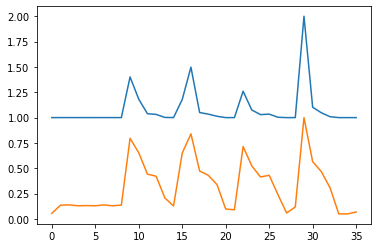

In [ ]:
# This cell just visualises the transformation without actually storing it.
plt.plot([(a**4) + 1 for a in audio_volumes['drums']])
plt.plot([a for a in audio_volumes['drums']])

In [ ]:
# Actually store the manipulation for the 'drums' track
audio_volumes['drums'] = audio_volumes['drums']**4 + 1

If you want to further manipulate the values using the bézier curve editor at https://keyframe-string-generator.glitch.me/ , you can output the keyframe string using the cell below:

In [ ]:
def get_keyframe_string(track):
    global audio_volumes
    array = audio_volumes[track]
    string_array = []
    for i, val in enumerate(array):
        string_array.append(f'{i}: ({val})')
    return ', '.join(string_array)

get_keyframe_string('drums')

## Instructions for setting parameters:

Most of the parameters can be set the same way as in the basic notebook here:  https://colab.research.google.com/github/chigozienri/VQGAN-CLIP-animations/blob/main/VQGAN-CLIP-animations.ipynb

However, if you set one of the purely numerical parameters in the format "audio: filename", it will use the volume data from that audio track.

This works on angle, zoom, translation_x, translation_y, and iterations_per_frame.

Note that if the audio is too short, then the final value of the audio will be repeated to fill space.

In [ ]:
#@title Parameters
# @markdown The first time you run this cell with a given model selected, it will take a while because it will download the model. After that, if you change parameters, it won't take as long.

key_frames = True #@param {type:"boolean"}
text_prompts = "10:(Apple: 1)" #@param {type:"string"}
width =  400#@param {type:"number"}
height =  400#@param {type:"number"}
model = "vqgan_imagenet_f16_16384" #@param ["vqgan_imagenet_f16_16384", "vqgan_imagenet_f16_1024", "wikiart_16384", "coco", "faceshq", "sflckr"]
interval =  1#@param {type:"number"}
initial_image = ""#@param {type:"string"}
target_images = ""#@param {type:"string"}
seed = 1#@param {type:"number"}
max_frames = 40#@param {type:"number"}
angle = "0: (0)"#@param {type:"string"}
zoom = "audio: drums"#@param {type:"string"}
translation_x = "0: (0)"#@param {type:"string"}
translation_y = "0: (0)"#@param {type:"string"}
iterations_per_frame = "0: (10)"#@param {type:"string"}
save_all_iterations = False#@param {type:"boolean"}

# option -C - skips download if already exists
!curl -C - -L -o {model}.yaml -C - 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #ImageNet 1024
!curl -C - -L -o {model}.ckpt -C - 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fckpts%2Flast.ckpt&dl=1'  #ImageNet 1024

if initial_image != "":
    print(
        "WARNING: You have specified an initial image. Note that the image resolution "
        "will be inherited from this image, not whatever width and height you specified. "
        "If the initial image resolution is too high, this can result in out of memory errors."
    )
elif width * height > 160000:
    print(
        "WARNING: The width and height you have specified may be too high, in which case "
        "you will encounter out of memory errors either at the image generation stage or the "
        "video synthesis stage. If so, try reducing the resolution"
    )
model_names={
    "vqgan_imagenet_f16_16384": 'ImageNet 16384',
    "vqgan_imagenet_f16_1024":"ImageNet 1024", 
    "wikiart_1024":"WikiArt 1024",
    "wikiart_16384":"WikiArt 16384",
    "coco":"COCO-Stuff",
    "faceshq":"FacesHQ",
    "sflckr":"S-FLCKR"
}
model_name = model_names[model]

if seed == -1:
    seed = None


def parse_key_frames(string, prompt_parser=None):
    """Given a string representing frame numbers paired with parameter values at that frame,
    return a dictionary with the frame numbers as keys and the parameter values as the values.

    Parameters
    ----------
    string: string
        Frame numbers paired with parameter values at that frame number, in the format
        'framenumber1: (parametervalues1), framenumber2: (parametervalues2), ...'
    prompt_parser: function or None, optional
        If provided, prompt_parser will be applied to each string of parameter values.
    
    Returns
    -------
    dict
        Frame numbers as keys, parameter values at that frame number as values

    Raises
    ------
    RuntimeError
        If the input string does not match the expected format.
    
    Examples
    --------
    >>> parse_key_frames("10:(Apple: 1| Orange: 0), 20: (Apple: 0| Orange: 1| Peach: 1)")
    {10: 'Apple: 1| Orange: 0', 20: 'Apple: 0| Orange: 1| Peach: 1'}

    >>> parse_key_frames("10:(Apple: 1| Orange: 0), 20: (Apple: 0| Orange: 1| Peach: 1)", prompt_parser=lambda x: x.lower()))
    {10: 'apple: 1| orange: 0', 20: 'apple: 0| orange: 1| peach: 1'}
    """
    import re
    pattern = r'((?P<frame>[0-9]+):[\s]*[\(](?P<param>[\S\s]*?)[\)])'
    frames = dict()
    for match_object in re.finditer(pattern, string):
        frame = int(match_object.groupdict()['frame'])
        param = match_object.groupdict()['param']
        if prompt_parser:
            frames[frame] = prompt_parser(param)
        else:
            frames[frame] = param

    if frames == {} and len(string) != 0:
        raise RuntimeError('Key Frame string not correctly formatted')
    return frames

def get_inbetweens(key_frames, integer=False):
    """Given a dict with frame numbers as keys and a parameter value as values,
    return a pandas Series containing the value of the parameter at every frame from 0 to max_frames.
    Any values not provided in the input dict are calculated by linear interpolation between
    the values of the previous and next provided frames. If there is no previous provided frame, then
    the value is equal to the value of the next provided frame, or if there is no next provided frame,
    then the value is equal to the value of the previous provided frame. If no frames are provided,
    all frame values are NaN.

    Parameters
    ----------
    key_frames: dict
        A dict with integer frame numbers as keys and numerical values of a particular parameter as values.
    integer: Bool, optional
        If True, the values of the output series are converted to integers.
        Otherwise, the values are floats.
    
    Returns
    -------
    pd.Series
        A Series with length max_frames representing the parameter values for each frame.
    
    Examples
    --------
    >>> max_frames = 5
    >>> get_inbetweens({1: 5, 3: 6})
    0    5.0
    1    5.0
    2    5.5
    3    6.0
    4    6.0
    dtype: float64

    >>> get_inbetweens({1: 5, 3: 6}, integer=True)
    0    5
    1    5
    2    5
    3    6
    4    6
    dtype: int64
    """
    key_frame_series = pd.Series([np.nan for a in range(max_frames)])
    for i, value in key_frames.items():
        key_frame_series[i] = value
    key_frame_series = key_frame_series.astype(float)
    key_frame_series = key_frame_series.interpolate(limit_direction='both')
    if integer:
        return key_frame_series.astype(int)
    return key_frame_series

def split_key_frame_text_prompts(frames):
    """Given a dict with frame numbers as keys and a string containing several text prompts
    and their corresponding value at that frame number as values, return a list of length
    max_frames of strings representing the values of each text prompt at every frame, where
    the value of frames not given in the input dict are calculated by linear interpolation.

    Parameters
    ----------
    frames: dict
        A dict with frame numbers as keys and strings containing text prompts in the format
        'textprompt1: valueatframe | textprompt2: valueatframe | ...'
    
    Returns
    -------
    list of strings
        A list of strings of length max_frames.
    
    Examples
    --------
    >>> max_frames = 3
    >>> split_key_frame_text_prompts({1: 'Apple: 1| Orange: 0', 2: 'Apple: 0| Orange: 1| Peach: 1'})
    [
        'Apple: 1.0 | Orange: 0.0 | Peach: 1.0',
        'Apple: 1.0 | Orange: 0.0 | Peach: 1.0',
        'Apple: 0.0 | Orange: 1.0 | Peach: 1.0'
    ]


    """
    prompt_dict = dict()
    for i, parameters in frames.items():
        prompts = parameters.split('|')
        for prompt in prompts:
            string, value = prompt.split(':')
            string = string.strip()
            value = float(value.strip())
            if string in prompt_dict:
                prompt_dict[string][i] = value
            else:
                prompt_dict[string] = {i: value}
    prompt_series_dict = dict()
    for prompt, values in prompt_dict.items():
        value_string = (
            ', '.join([f'{value}: ({values[value]})' for value in values])
        )
        prompt_series = get_inbetweens(parse_key_frames(value_string))
        prompt_series_dict[prompt] = prompt_series
    prompt_list = []
    for i in range(max_frames):
        prompt_list.append(
            ' | '.join(
                [f'{prompt}: {prompt_series_dict[prompt][i]}'
                 for prompt in prompt_series_dict]
            )
        )
    return prompt_list

if key_frames:
    try:
        text_prompts_series = split_key_frame_text_prompts(
            parse_key_frames(text_prompts)
        )
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `text_prompts` correctly for key frames.\n"
            "Attempting to interpret `text_prompts` as "
            f'"0: ({text_prompts}:1)"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        text_prompts = f"0: ({text_prompts}:1)"
        text_prompts_series = split_key_frame_text_prompts(
            parse_key_frames(text_prompts)
        )

    try:
        target_images_series = split_key_frame_text_prompts(
            parse_key_frames(target_images)
        )
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `target_images` correctly for key frames.\n"
            "Attempting to interpret `target_images` as "
            f'"0: ({target_images}:1)"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        target_images = f"0: ({target_images}:1)"
        target_images_series = split_key_frame_text_prompts(
            parse_key_frames(target_images)
        )

    if angle.startswith('audio: '):
        track_name = angle[len('audio: '):]
        angle_series = audio_volumes[track_name]
        # Repeat last frame enough that we don't run out.
        if len(angle_series) < max_frames:
            extra_frames = [angle_series[-1]]*(max_frames-len(angle_series))
            angle_series = np.append(angle_series, extra_frames)
    else:
        try:
            angle_series = get_inbetweens(parse_key_frames(angle))
        except RuntimeError as e:
            print(
                "WARNING: You have selected to use key frames, but you have not "
                "formatted `angle` correctly for key frames.\n"
                "Attempting to interpret `angle` as "
                f'"0: ({angle})"\n'
                "Please read the instructions to find out how to use key frames "
                "correctly.\n"
            )
            angle = f"0: ({angle})"
            angle_series = get_inbetweens(parse_key_frames(angle))

    if zoom.startswith('audio: '):
        track_name = zoom[len('audio: '):]
        zoom_series = audio_volumes[track_name]
        # Repeat last frame enough that we don't run out.
        if len(zoom_series) < max_frames:
            extra_frames = [zoom_series[-1]]*(max_frames-len(zoom_series))
            zoom_series = np.append(zoom_series, extra_frames)
    else:
        try:
            zoom_series = get_inbetweens(parse_key_frames(zoom))
        except RuntimeError as e:
            print(
                "WARNING: You have selected to use key frames, but you have not "
                "formatted `zoom` correctly for key frames.\n"
                "Attempting to interpret `zoom` as "
                f'"0: ({zoom})"\n'
                "Please read the instructions to find out how to use key frames "
                "correctly.\n"
            )
            zoom = f"0: ({zoom})"
            zoom_series = get_inbetweens(parse_key_frames(zoom))


    if translation_x.startswith('audio: '):
        track_name = translation_x[len('audio: '):]
        translation_x_series = audio_volumes[track_name]
        # Repeat last frame enough that we don't run out.
        if len(translation_x_series) < max_frames:
            extra_frames = [translation_x_series[-1]]*(max_frames-len(translation_x_series))
            translation_x_series = np.append(translation_x_series, extra_frames)
    else:
        try:
            translation_x_series = get_inbetweens(parse_key_frames(translation_x))
        except RuntimeError as e:
            print(
                "WARNING: You have selected to use key frames, but you have not "
                "formatted `translation_x` correctly for key frames.\n"
                "Attempting to interpret `translation_x` as "
                f'"0: ({translation_x})"\n'
                "Please read the instructions to find out how to use key frames "
                "correctly.\n"
            )
            translation_x = f"0: ({translation_x})"
            translation_x_series = get_inbetweens(parse_key_frames(translation_x))


    if translation_y.startswith('audio: '):
        track_name = translation_y[len('audio: '):]
        translation_y_series = audio_volumes[track_name]
        # Repeat last frame enough that we don't run out.
        if len(translation_y_series) < max_frames:
            extra_frames = [translation_y_series[-1]]*(max_frames-len(translation_y_series))
            translation_y_series = np.append(translation_y_series, extra_frames)
    else:
        try:
            translation_y_series = get_inbetweens(parse_key_frames(translation_y))
        except RuntimeError as e:
            print(
                "WARNING: You have selected to use key frames, but you have not "
                "formatted `translation_y` correctly for key frames.\n"
                "Attempting to interpret `translation_y` as "
                f'"0: ({translation_y})"\n'
                "Please read the instructions to find out how to use key frames "
                "correctly.\n"
            )
            translation_y = f"0: ({translation_y})"
            translation_y_series = get_inbetweens(parse_key_frames(translation_y))


    if iterations_per_frame.startswith('audio: '):
        track_name = iterations_per_frame[len('audio: '):]
        iterations_per_frame_series = audio_volumes[track_name]
        # Repeat last frame enough that we don't run out.
        if len(iterations_per_frame_series) < max_frames:
            extra_frames = [iterations_per_frame_series[-1]]*(max_frames-len(iterations_per_frame_series))
            iterations_per_frame_series = np.append(iterations_per_frame_series, extra_frames)
    else:
        try:
            iterations_per_frame_series = get_inbetweens(
                parse_key_frames(iterations_per_frame), integer=True
            )
        except RuntimeError as e:
            print(
                "WARNING: You have selected to use key frames, but you have not "
                "formatted `iterations_per_frame` correctly for key frames.\n"
                "Attempting to interpret `iterations_per_frame` as "
                f'"0: ({iterations_per_frame})"\n'
                "Please read the instructions to find out how to use key frames "
                "correctly.\n"
            )
            iterations_per_frame = f"0: ({iterations_per_frame})"
            
            iterations_per_frame_series = get_inbetweens(
                parse_key_frames(iterations_per_frame), integer=True
            )
else:
    text_prompts = [phrase.strip() for phrase in text_prompts.split("|")]
    if text_prompts == ['']:
        text_prompts = []
    if target_images == "None" or not target_images:
        target_images = []
    else:
        target_images = target_images.split("|")
        target_images = [image.strip() for image in target_images]

    angle = float(angle)
    zoom = float(zoom)
    translation_x = float(translation_x)
    translation_y = float(translation_y)
    iterations_per_frame = int(iterations_per_frame)

args = argparse.Namespace(
    prompts=text_prompts,
    image_prompts=target_images,
    noise_prompt_seeds=[],
    noise_prompt_weights=[],
    size=[width, height],
    init_weight=0.,
    clip_model='ViT-B/32',
    vqgan_config=f'{model}.yaml',
    vqgan_checkpoint=f'{model}.ckpt',
    step_size=0.1,
    cutn=64,
    cut_pow=1.,
    display_freq=interval,
    seed=seed,
)

** Resuming transfer from byte position 645
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
** Resuming transfer from byte position 957954257
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0


The following cell deletes any frames already in the steps directory. Make sure you have saved any frames you want to keep from previous runs

In [ ]:
path = f'{working_dir}/steps'
!rm -r {path}
!mkdir --parents {path}

In [ ]:
if key_frames:
    # key frame filename would be too long
    filename = "video.mp4"
else:
    filename = f"{'_'.join(text_prompts).replace(' ', '')}.mp4"
filepath = f'{working_dir}/{filename}'

Cleared Accounted PIDs for GPU 00000000:00:04.0.
All done.
Using device: cuda:0
Using seed: 1
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

8.19kB [00:00, 491kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt


100%|███████████████████████████████████████| 338M/338M [00:14<00:00, 25.0MiB/s]


text_prompts: ['Apple: 1.0']angle: 0.0 zoom: 1.0000094799010024 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 10


0it [00:00, ?it/s]

i: 1, loss: 0.834428, losses: 0.834428


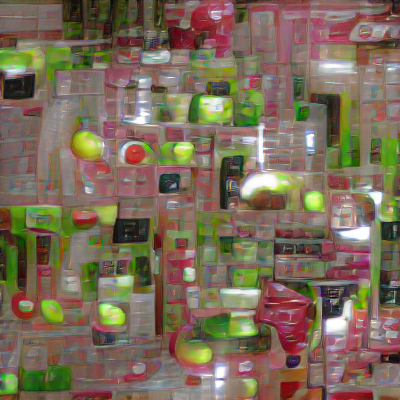

text_prompts: ['Apple: 1.0']angle: 0.0 zoom: 1.0003398213325325 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 10


0it [00:00, ?it/s]

i: 2, loss: 0.774776, losses: 0.774776


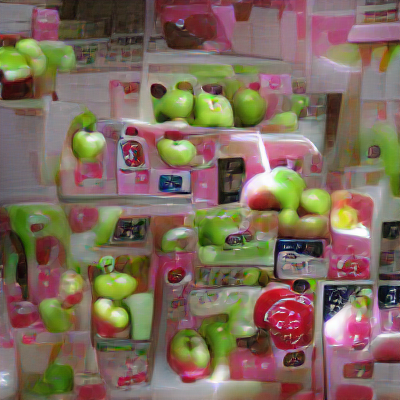

text_prompts: ['Apple: 1.0']angle: 0.0 zoom: 1.0003762895148431 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 10


0it [00:00, ?it/s]

i: 3, loss: 0.757255, losses: 0.757255


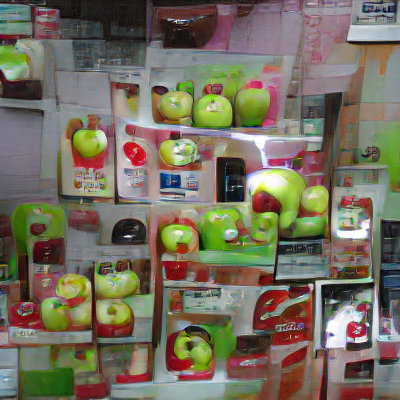

text_prompts: ['Apple: 1.0']angle: 0.0 zoom: 1.000289696217177 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 10


0it [00:00, ?it/s]

i: 4, loss: 0.737877, losses: 0.737877


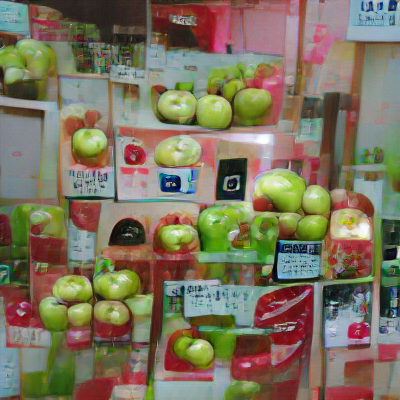

text_prompts: ['Apple: 1.0']angle: 0.0 zoom: 1.0003037315411885 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 10


0it [00:00, ?it/s]

i: 5, loss: 0.725283, losses: 0.725283


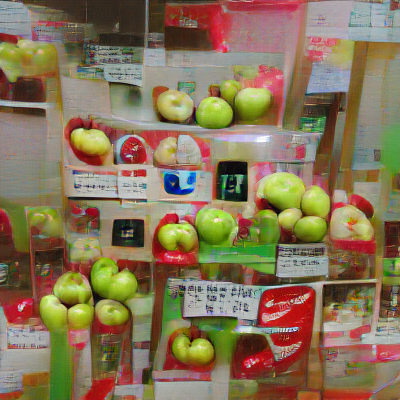

text_prompts: ['Apple: 1.0']angle: 0.0 zoom: 1.000288367001177 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 10


0it [00:00, ?it/s]

i: 6, loss: 0.716264, losses: 0.716264


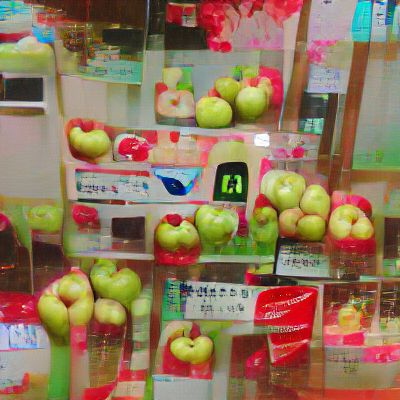

text_prompts: ['Apple: 1.0']angle: 0.0 zoom: 1.0003694422584843 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 10


0it [00:00, ?it/s]

i: 7, loss: 0.711908, losses: 0.711908


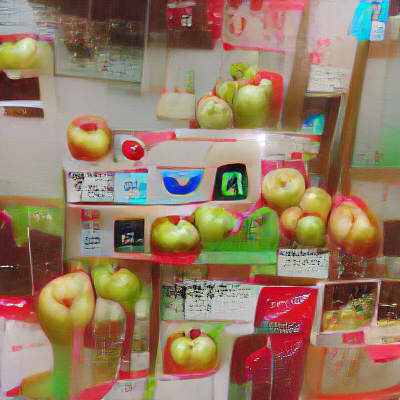

text_prompts: ['Apple: 1.0']angle: 0.0 zoom: 1.0002862014706242 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 10


0it [00:00, ?it/s]

i: 8, loss: 0.712092, losses: 0.712092


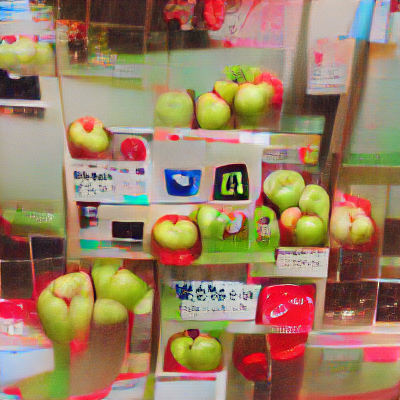

text_prompts: ['Apple: 1.0']angle: 0.0 zoom: 1.0003586882834692 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 10


0it [00:00, ?it/s]

i: 9, loss: 0.715463, losses: 0.715463


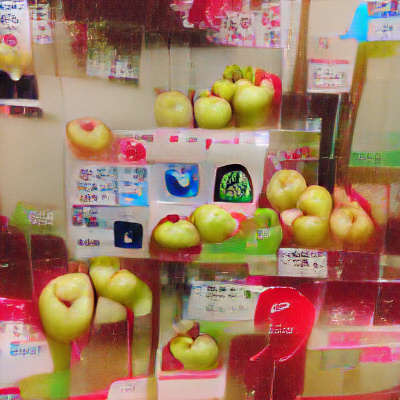

text_prompts: ['Apple: 1.0']angle: 0.0 zoom: 1.401440291600364 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 10


0it [00:00, ?it/s]

i: 10, loss: 0.715251, losses: 0.715251


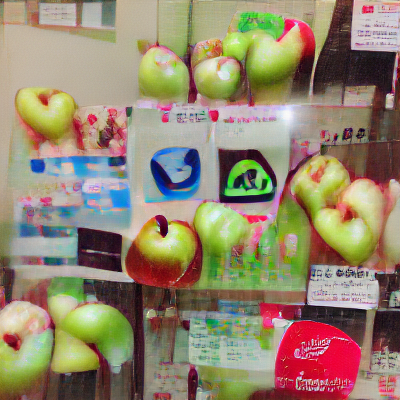

text_prompts: ['Apple: 1.0']angle: 0.0 zoom: 1.1817611793024183 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 10


0it [00:00, ?it/s]

i: 11, loss: 0.70897, losses: 0.70897


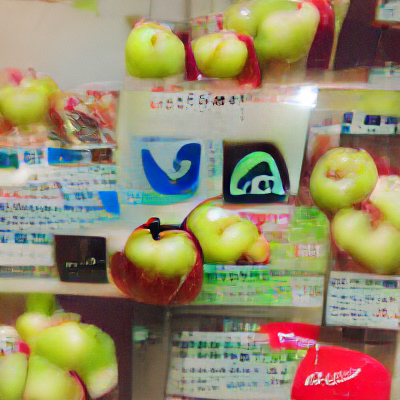

text_prompts: ['Apple: 1.0']angle: 0.0 zoom: 1.0382332987287703 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 10


0it [00:00, ?it/s]

i: 12, loss: 0.697976, losses: 0.697976


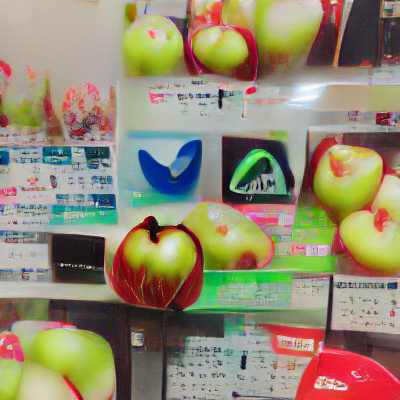

text_prompts: ['Apple: 1.0']angle: 0.0 zoom: 1.031654869773383 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 10


0it [00:00, ?it/s]

i: 13, loss: 0.696279, losses: 0.696279


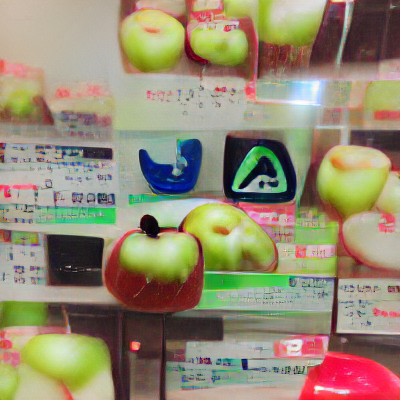

text_prompts: ['Apple: 1.0']angle: 0.0 zoom: 1.0018701635306326 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 10


0it [00:00, ?it/s]

i: 14, loss: 0.691209, losses: 0.691209


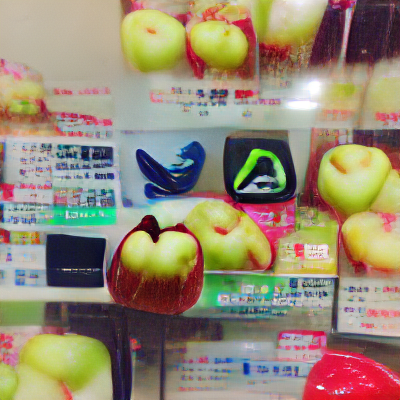

text_prompts: ['Apple: 1.0']angle: 0.0 zoom: 1.000272935937091 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 10


0it [00:00, ?it/s]

i: 15, loss: 0.686737, losses: 0.686737


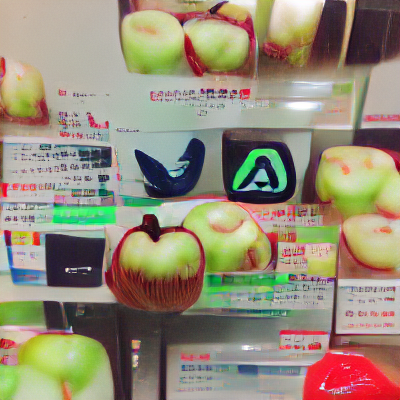

text_prompts: ['Apple: 1.0']angle: 0.0 zoom: 1.1787538618615878 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 10


0it [00:00, ?it/s]

i: 16, loss: 0.690806, losses: 0.690806


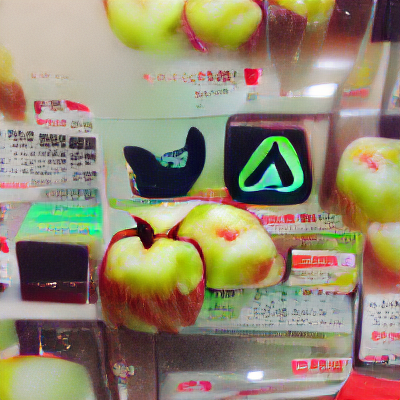

text_prompts: ['Apple: 1.0']angle: 0.0 zoom: 1.4977463338715988 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 10


0it [00:00, ?it/s]

i: 17, loss: 0.702654, losses: 0.702654


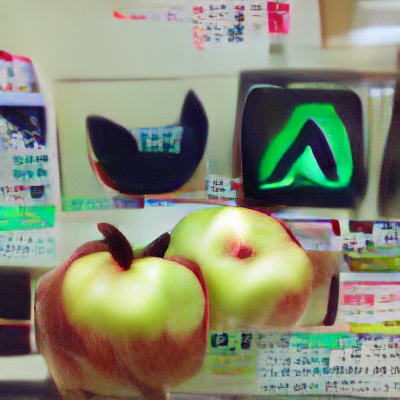

text_prompts: ['Apple: 1.0']angle: 0.0 zoom: 1.0501541191172807 translation_x: 0.0 translation_y: 0.0 iterations_per_frame: 10


0it [00:00, ?it/s]

In [ ]:
#@title Actually do the run...

# Delete memory from previous runs
!nvidia-smi -caa
for var in ['device', 'model', 'perceptor', 'z']:
  try:
      del globals()[var]
  except:
      pass

try:
    import gc
    gc.collect()
except:
    pass

try:
    torch.cuda.empty_cache()
except:
    pass

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if not key_frames:
    if text_prompts:
        print('Using text prompts:', text_prompts)
    if target_images:
        print('Using image prompts:', target_images)
if args.seed is None:
    seed = torch.seed()
else:
    seed = args.seed
torch.manual_seed(seed)
print('Using seed:', seed)
 
model = load_vqgan_model(args.vqgan_config, args.vqgan_checkpoint).to(device)
perceptor = clip.load(args.clip_model, jit=False)[0].eval().requires_grad_(False).to(device)
 
cut_size = perceptor.visual.input_resolution
e_dim = model.quantize.e_dim
f = 2**(model.decoder.num_resolutions - 1)
make_cutouts = MakeCutouts(cut_size, args.cutn, cut_pow=args.cut_pow)
n_toks = model.quantize.n_e
toksX, toksY = args.size[0] // f, args.size[1] // f
sideX, sideY = toksX * f, toksY * f
z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]
stop_on_next_loop = False  # Make sure GPU memory doesn't get corrupted from cancelling the run mid-way through, allow a full frame to complete

def read_image_workaround(path):
    """OpenCV reads images as BGR, Pillow saves them as RGB. Work around
    this incompatibility to avoid colour inversions."""
    im_tmp = cv2.imread(path)
    return cv2.cvtColor(im_tmp, cv2.COLOR_BGR2RGB)

for i in range(max_frames):
    if stop_on_next_loop:
      break
    if key_frames:
        text_prompts = text_prompts_series[i]
        text_prompts = [phrase.strip() for phrase in text_prompts.split("|")]
        if text_prompts == ['']:
            text_prompts = []
        args.prompts = text_prompts

        target_images = target_images_series[i]

        if target_images == "None" or not target_images:
            target_images = []
        else:
            target_images = target_images.split("|")
            target_images = [image.strip() for image in target_images]
        args.image_prompts = target_images

        angle = angle_series[i]
        zoom = zoom_series[i]
        translation_x = translation_x_series[i]
        translation_y = translation_y_series[i]
        iterations_per_frame = iterations_per_frame_series[i]
        print(
            f'text_prompts: {text_prompts}'
            f'angle: {angle}',
            f'zoom: {zoom}',
            f'translation_x: {translation_x}',
            f'translation_y: {translation_y}',
            f'iterations_per_frame: {iterations_per_frame}'
        )
    try:
        if i == 0 and initial_image != "":
            img_0 = read_image_workaround(initial_image)
            z, *_ = model.encode(TF.to_tensor(img_0).to(device).unsqueeze(0) * 2 - 1)
        elif i == 0 and not os.path.isfile(f'{working_dir}/steps/{i:04d}.png'):
            one_hot = F.one_hot(
                torch.randint(n_toks, [toksY * toksX], device=device), n_toks
            ).float()
            z = one_hot @ model.quantize.embedding.weight
            z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2)
        else:
            if save_all_iterations:
                img_0 = read_image_workaround(
                    f'{working_dir}/steps/{i:04d}_{iterations_per_frame}.png')
            else:
                img_0 = read_image_workaround(f'{working_dir}/steps/{i:04d}.png')

            center = (1*img_0.shape[1]//2, 1*img_0.shape[0]//2)
            trans_mat = np.float32(
                [[1, 0, translation_x],
                [0, 1, translation_y]]
            )
            rot_mat = cv2.getRotationMatrix2D( center, angle, zoom )

            trans_mat = np.vstack([trans_mat, [0,0,1]])
            rot_mat = np.vstack([rot_mat, [0,0,1]])
            transformation_matrix = np.matmul(rot_mat, trans_mat)

            img_0 = cv2.warpPerspective(
                img_0,
                transformation_matrix,
                (img_0.shape[1], img_0.shape[0]),
                borderMode=cv2.BORDER_WRAP
            )
            z, *_ = model.encode(TF.to_tensor(img_0).to(device).unsqueeze(0) * 2 - 1)
        i += 1

        z_orig = z.clone()
        z.requires_grad_(True)
        opt = optim.Adam([z], lr=args.step_size)

        normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                        std=[0.26862954, 0.26130258, 0.27577711])

        pMs = []

        for prompt in args.prompts:
            txt, weight, stop = parse_prompt(prompt)
            embed = perceptor.encode_text(clip.tokenize(txt).to(device)).float()
            pMs.append(Prompt(embed, weight, stop).to(device))

        for prompt in args.image_prompts:
            path, weight, stop = parse_prompt(prompt)
            img = resize_image(Image.open(path).convert('RGB'), (sideX, sideY))
            batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
            embed = perceptor.encode_image(normalize(batch)).float()
            pMs.append(Prompt(embed, weight, stop).to(device))

        for seed, weight in zip(args.noise_prompt_seeds, args.noise_prompt_weights):
            gen = torch.Generator().manual_seed(seed)
            embed = torch.empty([1, perceptor.visual.output_dim]).normal_(generator=gen)
            pMs.append(Prompt(embed, weight).to(device))

        def synth(z):
            z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
            return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

        def add_xmp_data(filename):
            imagen = ImgTag(filename=filename)
            imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'creator', 'VQGAN+CLIP', {"prop_array_is_ordered":True, "prop_value_is_array":True})
            if args.prompts:
                imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'title', " | ".join(args.prompts), {"prop_array_is_ordered":True, "prop_value_is_array":True})
            else:
                imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'title', 'None', {"prop_array_is_ordered":True, "prop_value_is_array":True})
            imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'i', str(i), {"prop_array_is_ordered":True, "prop_value_is_array":True})
            imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'model', model_name, {"prop_array_is_ordered":True, "prop_value_is_array":True})
            imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'seed',str(seed) , {"prop_array_is_ordered":True, "prop_value_is_array":True})
            imagen.close()

        def add_stegano_data(filename):
            data = {
                "title": " | ".join(args.prompts) if args.prompts else None,
                "notebook": "VQGAN+CLIP",
                "i": i,
                "model": model_name,
                "seed": str(seed),
            }
            lsb.hide(filename, json.dumps(data)).save(filename)

        @torch.no_grad()
        def checkin(i, losses):
            losses_str = ', '.join(f'{loss.item():g}' for loss in losses)
            tqdm.write(f'i: {i}, loss: {sum(losses).item():g}, losses: {losses_str}')
            out = synth(z)
            TF.to_pil_image(out[0].cpu()).save('progress.png')
            add_stegano_data('progress.png')
            add_xmp_data('progress.png')
            display.display(display.Image('progress.png'))

        def save_output(i, img, suffix=None):
            filename = \
                f"{working_dir}/steps/{i:04}{'_' + suffix if suffix else ''}.png"
            imageio.imwrite(filename, np.array(img))
            add_stegano_data(filename)
            add_xmp_data(filename)

        def ascend_txt(i, save=True, suffix=None):
            out = synth(z)
            iii = perceptor.encode_image(normalize(make_cutouts(out))).float()

            result = []

            if args.init_weight:
                result.append(F.mse_loss(z, z_orig) * args.init_weight / 2)

            for prompt in pMs:
                result.append(prompt(iii))
            img = np.array(out.mul(255).clamp(0, 255)[0].cpu().detach().numpy().astype(np.uint8))[:,:,:]
            img = np.transpose(img, (1, 2, 0))
            if save:
                save_output(i, img, suffix=suffix)
            return result

        def train(i, save=True, suffix=None):
            opt.zero_grad()
            lossAll = ascend_txt(i, save=save, suffix=suffix)
            if i % args.display_freq == 0 and save:
                checkin(i, lossAll)
            loss = sum(lossAll)
            loss.backward()
            opt.step()
            with torch.no_grad():
                z.copy_(z.maximum(z_min).minimum(z_max))

        with tqdm() as pbar:
            if iterations_per_frame == 0:
                save_output(i, img_0)
            j = 1
            while True:
                suffix = (str(j) if save_all_iterations else None)
                if j >= iterations_per_frame:
                    train(i, save=True, suffix=suffix)
                    break
                if save_all_iterations:
                    train(i, save=True, suffix=suffix)
                else:
                    train(i, save=False, suffix=suffix)
                j += 1
                pbar.update()
    except KeyboardInterrupt:
      stop_on_next_loop = True
      pass

# Optional: SRCNN for increasing resolution

In [ ]:
!git clone https://github.com/Mirwaisse/SRCNN.git
!curl https://raw.githubusercontent.com/chigozienri/SRCNN/master/models/model_2x.pth -o model_2x.pth

Cloning into 'SRCNN'...
remote: Enumerating objects: 415, done.
remote: Total 415 (delta 0), reused 0 (delta 0), pack-reused 415
Receiving objects: 100% (415/415), 61.20 MiB | 22.85 MiB/s, done.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35479  100 35479    0     0   183k      0 --:--:-- --:--:-- --:--:--  183k


In [ ]:
# @title Increase Resolution

# import subprocess in case this cell is run without the above cells
import subprocess
# Set zoomed = True if this cell is run
zoomed = True

init_frame = 1#@param {type:"number"}
last_frame = i#@param {type:"number"}

for i in range(init_frame, last_frame + 1): #
    filename = f"{i:04}.png"
    cmd = [
        'python',
        '/content/SRCNN/run.py',
        '--zoom_factor',
        '2',  # Note if you increase this, you also need to change the model.
        '--model',
        '/content/model_2x.pth',  # 2x, 3x and 4x are available from the repo above
        '--image',
        filename,
        '--cuda'
    ]
    print(f'Upscaling frame {i}')

    process = subprocess.Popen(cmd, cwd=f'{working_dir}/steps/')
    stdout, stderr = process.communicate()
    if process.returncode != 0:
        print(stderr)
        print(
            "You may be able to avoid this error by backing up the frames,"
            "restarting the notebook, and running only the video synthesis cells,"
            "or by decreasing the resolution of the image generation steps. "
            "If you restart the notebook, you will have to define the `filepath` manually"
            "by adding `filepath = 'PATH_TO_THE_VIDEO'` to the beginning of this cell. "
            "If these steps do not work, please post the traceback in the github."
        )
        raise RuntimeError(stderr)

## Make a video of the results

To generate a video with the frames, run the cell below. You can modify the number of FPS, the initial frame, the last frame, etc.

Note that this video does not include the audio by default, (though it should sync up with the audio in a different program, if the fps has been set correctly)

In [ ]:
# @title Create video
# import subprocess in case this cell is run without the above cells
import subprocess

init_frame = 1#@param {type:"number"} This is the frame where the video will start
last_frame = i#@param {type:"number"} You can change i to the number of the last frame you want to generate. It will raise an error if that number of frames does not exist.
fps = 12#@param {type:"number"}

frames = []
# tqdm.write('Generating video...')
try:
    zoomed
except NameError:
    image_path = f'{working_dir}/steps/%04d.png'
else:
    image_path = f'{working_dir}/steps/zoomed_%04d.png'

cmd = [
    'ffmpeg',
    '-y',
    '-vcodec',
    'png',
    '-r',
    str(fps),
    '-start_number',
    str(init_frame),
    '-i',
    image_path,
    # '-i',
    # '../input.mp3',
    '-c:v',
    'libx264',
    # '-c:a',
    # 'aac',
    '-frames:v',
    str(last_frame-init_frame),
    '-vf',
    f'fps={fps}',
    '-pix_fmt',
    'yuv420p',
    '-crf',
    '17',
    '-preset',
    'veryslow',
    filepath
]

process = subprocess.Popen(cmd, cwd=f'{working_dir}/steps/', stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()
if process.returncode != 0:
    print(stderr)
    print(
        "You may be able to avoid this error by backing up the frames,"
        "restarting the notebook, and running only the video synthesis cells,"
        "or by decreasing the resolution of the image generation steps. "
        "If you restart the notebook, you will have to define the `filepath` manually"
        "by adding `filepath = 'PATH_TO_THE_VIDEO'` to the beginning of this cell. "
        "If these steps do not work, please post the traceback in the github."
    )
    raise RuntimeError(stderr)
else:
    print("The video is ready")

In [ ]:
# @title See video in the browser
# @markdown This process may take a little longer. If you don't want to wait, download it by executing the next cell instead of using this cell.
from base64 import b64encode
from IPython import display
mp4 = open(filepath,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
display.HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
# @title Download video
from google.colab import files
files.download(filepath)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Optional: Super-Slomo for smoothing movement

This step might run out of memory if you run it right after the steps above. If it does, restart the notebook, upload a saved copy of the video from the previous step (or get it from google drive) and define the variable `filepath` with the path to the video before running the cells below again. Note that this might break audio syncing - you can use it to interpolate frames to add smoothness, but if you slow down then it will no longer align with audio.

In [ ]:
# @title Download Super-Slomo model
!git clone -q --depth 1 https://github.com/avinashpaliwal/Super-SloMo.git
from os.path import exists
def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}
  
pretrained_model = 'SuperSloMo.ckpt'
if not exists(pretrained_model):
  download_from_google_drive('1IvobLDbRiBgZr3ryCRrWL8xDbMZ-KnpF', pretrained_model)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   1271      0 --:--:-- --:--:-- --:--:--  1271
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  151M  100  151M    0     0  64.7M      0  0:00:02  0:00:02 --:--:--  206M


In [ ]:
# import subprocess in case this cell is run without the above cells
import subprocess

SLOW_MOTION_FACTOR = 3#@param {type:"number"}
TARGET_FPS = 12#@param {type:"number"}

cmd1 = [
    'python',
    'Super-SloMo/video_to_slomo.py',
    '--checkpoint',
    pretrained_model,
    '--video',
    filepath,
    '--sf',
    str(SLOW_MOTION_FACTOR),
    '--fps',
    str(TARGET_FPS),
    '--output',
    f'{filepath}-slomo.mkv',
]
process = subprocess.Popen(cmd1, cwd=f'/content', stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()
if process.returncode != 0:
    raise RuntimeError(stderr)

cmd2 = [
    'ffmpeg',
    '-i',
    f'{filepath}-slomo.mkv',
    '-pix_fmt',
    'yuv420p',
    '-crf',
    '17',
    '-preset',
    'veryslow',
    f'{filepath}-slomo.mp4',
]

process = subprocess.Popen(cmd2, cwd=f'/content', stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()
if process.returncode != 0:
    raise RuntimeError(stderr)
    print(stderr)
    print(
        "You may be able to avoid this error by backing up the frames,"
        "restarting the notebook, and running only the video synthesis cells,"
        "or by decreasing the resolution of the image generation steps. "
        "If you restart the notebook, you will have to define the `filepath` manually"
        "by adding `filepath = 'PATH_TO_THE_VIDEO'` to the beginning of this cell. "
        "If these steps do not work, please post the traceback in the github."
    )


In [ ]:
# @title See video in the browser
# @markdown This process may take a little longer. If you don't want to wait, download it by executing the next cell instead of using this cell.
from base64 import b64encode
from IPython import display
mp4 = open(f'{filepath}-slomo.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
display.HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
# @title Download video
from google.colab import files
files.download(f'{filepath}-slomo.mp4')